### Zero Shot Unlearning - Gated Knowledge Transfer
#### Dataset - CIFAR-10

#### Importing Libraries:

In [3]:
# Necessary Imports
import os
import torch
import requests
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from torchvision.models import resnet18
import torch.nn.functional as F
import pandas as pd
from torchvision.utils import make_grid
import math

torch.manual_seed(100)

In [4]:
# Define the device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Data Pre-processing:

In [5]:
# Define transformations
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

# Load CIFAR-10 dataset:

# Loading train set: 50000 images
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=normalize)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# Loading test set: 10000 images
held_out = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=normalize)

# Splitting test data into test and validation set: test = 5000 images, val = 5000 images
test_set, val_set = torch.utils.data.random_split(held_out, [5000, 5000])

test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### Importing ResNet18 Model:

In [6]:
# ResNet18
# Download pre-trained weights:
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# Load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### Class-wise split of data:

In [7]:
# Split the dataset by class
num_classes = 10 # total classes in CIFAR-10
classwise_train = {i: [] for i in range(num_classes)}
classwise_test = {i: [] for i in range(num_classes)}

for img, label in train_set:
    classwise_train[label].append((img, label))

for img, label in held_out:
    classwise_test[label].append((img, label))

#### Defining Functions:

In [8]:
# Define additional necessary functions and classes
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def KT_loss_generator(student_logits, teacher_logits, KL_temperature):
    if student_logits.shape != teacher_logits.shape:
        raise ValueError(f"Shape mismatch: {student_logits.shape} vs {teacher_logits.shape}")

    divergence_loss = divergence(student_logits, teacher_logits, KL_temperature)
    total_loss = -divergence_loss
    return total_loss

def KT_loss_student(student_logits, student_activations, teacher_logits, teacher_activations, KL_temperature=1, AT_beta=250):
    if student_logits.shape != teacher_logits.shape:
        raise ValueError(f"Shape mismatch: {student_logits.shape} vs {teacher_logits.shape}")

    divergence_loss = divergence(student_logits, teacher_logits, KL_temperature)
    if AT_beta > 0:
        at_loss = 0
        for i in range(len(student_activations)):
            at_loss = at_loss + AT_beta * attention_diff(student_activations[i], teacher_activations[i])
    else:
        at_loss = 0
    total_loss = divergence_loss + at_loss
    return total_loss

class LearnableLoader(nn.Module):
    def __init__(self, n_repeat_batch, num_channels=3, device='cuda'):
        super(LearnableLoader, self).__init__()
        self.batch_size = 256
        self.n_repeat_batch = n_repeat_batch
        self.z_dim = 128
        self.generator = Generator(self.z_dim, num_channels=num_channels).to(device=device)
        self.device = device
        self._running_repeat_batch_idx = 0
        self.z = torch.randn((self.batch_size, self.z_dim)).to(device=self.device)

    def __next__(self):
        if self._running_repeat_batch_idx == self.n_repeat_batch:
            self.z = torch.randn((self.batch_size, self.z_dim)).to(device=self.device)
            self._running_repeat_batch_idx = 0
        images = self.generator(self.z)
        self._running_repeat_batch_idx += 1
        return images

    def samples(self, n, grid=True):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn((n, self.z_dim)).to(device=self.device)
            images = self.generator(z).cpu()
            if grid:
                images = make_grid(images, nrow=round(math.sqrt(n)), normalize=True)
        self.generator.train()
        return images

    def __iter__(self):
        return self

def attention(x):
    return F.normalize(x.pow(2).mean(1).view(x.size(0), -1))

def attention_diff(x, y):
    return (attention(x) - attention(y)).pow(2).mean()

def divergence(student_logits, teacher_logits, KL_temperature):
    return F.kl_div(F.log_softmax(student_logits / KL_temperature, dim=1), F.softmax(teacher_logits / KL_temperature, dim=1))

class Generator(nn.Module):
    def __init__(self, z_dim, num_channels=3):
        super(Generator, self).__init__()
        prefinal_layer = nn.Conv2d(64, num_channels, 3, stride=1, padding=1)
        final_layer = nn.BatchNorm2d(num_channels, affine=True)
        self.layers = nn.Sequential(
            nn.Linear(z_dim, 128 * 8**2),
            View((-1, 128, 8, 8)),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            prefinal_layer,
            final_layer
        )

    def forward(self, z):
        return self.layers(z)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out, *_ = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['Loss'], result['Acc']))

@torch.no_grad()
def evaluate(model, val_loader, device='cuda'):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch
        output = validation_step(model, batch, device)
        outputs.append(output)
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, device='cuda'):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))


        # Validation phase
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
        sched.step(result['Loss'])
    return history

#### Forgetting Class 0 using GKT

In [9]:
# Define training process
forget_classes = [0]
forget_valid = [(img, label) for cls in forget_classes for img, label in classwise_test[cls]]
retain_valid = [(img, label) for cls in range(num_classes) if cls not in forget_classes for img, label in classwise_test[cls]]

forget_valid_dl = DataLoader(forget_valid, batch_size=128, num_workers=2, pin_memory=True, drop_last=True)
retain_valid_dl = DataLoader(retain_valid, batch_size=128, num_workers=2, pin_memory=True, drop_last=True)

print("Forget DataLoader settings:", forget_valid_dl.batch_size, forget_valid_dl.drop_last)
print("Retain DataLoader settings:", retain_valid_dl.batch_size, retain_valid_dl.drop_last)

Forget DataLoader settings: 128 True
Retain DataLoader settings: 128 True


In [10]:
import warnings
warnings.filterwarnings("ignore")

#### Evaluating the Teacher Model's performance on retain and forget class:

In [11]:
n_generator_iter = 1
n_student_iter = 10
n_repeat_batch = n_generator_iter + n_student_iter

student = resnet18(weights=None, num_classes=num_classes).to(DEVICE)
generator = LearnableLoader(n_repeat_batch=n_repeat_batch, num_channels=3, device=DEVICE).to(DEVICE)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler_generator = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.5, patience=2, verbose=True)

optimizer_student = torch.optim.Adam(student.parameters(), lr=0.001)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_student, mode='min', factor=0.5, patience=2, verbose=True)

print("Performance of Fully Trained Model on Forget Class")
history = [evaluate(model, forget_valid_dl, device=DEVICE)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Performance of Fully Trained Model on Retain Class")
history = [evaluate(model, retain_valid_dl, device=DEVICE)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

history = [evaluate(student, forget_valid_dl, device=DEVICE)]
AccForget = history[0]["Acc"]*100
ErrForget = history[0]["Loss"]

history = [evaluate(student, retain_valid_dl, device=DEVICE)]
AccRetain = history[0]["Acc"]*100
ErrRetain = history[0]["Loss"]

Performance of Fully Trained Model on Forget Class
Accuracy: 90.51339030265808
Loss: 0.34194526076316833
Performance of Fully Trained Model on Retain Class
Accuracy: 88.33705186843872
Loss: 0.4593777358531952


#### Training the unlearning model

In [12]:
# Defining a function to extract activations:
def get_activation(name, activations):
    def hook(model, input, output):
        activations[name] = output
    return hook

# Layers to hook
layers_to_hook = ['layer1', 'layer2', 'layer3', 'layer4']

# Register hooks for student model
student_activations = {}
for layer_name in layers_to_hook:
    layer = dict(student.named_modules())[layer_name]
    layer.register_forward_hook(get_activation(layer_name, student_activations))

# Register hooks for teacher model
teacher_activations = {}
for layer_name in layers_to_hook:
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(get_activation(layer_name, teacher_activations))

In [17]:
# Loop 1:
# total_pseudo_batches = 2000
# threshold = 0.02

import time

idx_pseudo = 0
total_n_pseudo_batches = 2000
n_pseudo_batches = 0
running_gen_loss = []
running_stu_loss = []

threshold = 0.02
KL_temperature = 1
AT_beta = 250

df = pd.DataFrame(columns=["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])

df = pd.concat([df, pd.DataFrame([{"Epochs": 0, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                   "ErrRetain": ErrRetain, "MeanGeneratorLoss": None, "MeanStudentLoss": None}])], ignore_index=True)

zero_count = 0

while n_pseudo_batches < total_n_pseudo_batches:
    epoch_start_time = time.time()  # Record the start time of the epoch

    x_pseudo = generator.__next__()

    preds = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]

    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits = student(x_pseudo)

        teacher_logits = model(x_pseudo)

        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())

    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):
        with torch.no_grad():
            teacher_logits = model(x_pseudo)

        student_logits = student(x_pseudo)

        student_activations_list = list(student_activations.values())
        teacher_activations_list = list(teacher_activations.values())

        student_total_loss = KT_loss_student(student_logits, student_activations_list,
                                             teacher_logits, teacher_activations_list,
                                             KL_temperature=KL_temperature, AT_beta=AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if (n_pseudo_batches % 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device=DEVICE)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device=DEVICE)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = pd.concat([df, pd.DataFrame([{"Epochs": n_pseudo_batches, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                               "ErrRetain": ErrRetain, "MeanGeneratorLoss": MeanGLoss, "MeanStudentLoss": MeanSLoss}])], ignore_index=True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history_forget[0]["Loss"])

            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_duration = epoch_end_time - epoch_start_time  # Calculate the duration
            print(f"Epoch {n_pseudo_batches} completed in {epoch_duration:.2f} seconds")


        n_pseudo_batches += 1

    idx_pseudo += 1


  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
1      0        0.0  11.160714  13.584733  12.847672          -0.182322   

   MeanStudentLoss  
1         8.972163  
Epoch 0 completed in 0.61 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
2     50        0.0  14.408483   3.804337   3.045884          -0.080513   

   MeanStudentLoss  
2         1.209489  
Epoch 50 completed in 0.61 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
3    100        0.0  15.078124   4.455238   3.179249           -0.09022   

   MeanStudentLoss  
3         1.147852  
Epoch 100 completed in 0.61 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
4    150        0.0   12.03125   5.244913   3.330179          -0.097826   

   MeanStudentLoss  
4         1.269762  
Epoch 150 completed in 0.67 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
5    200    

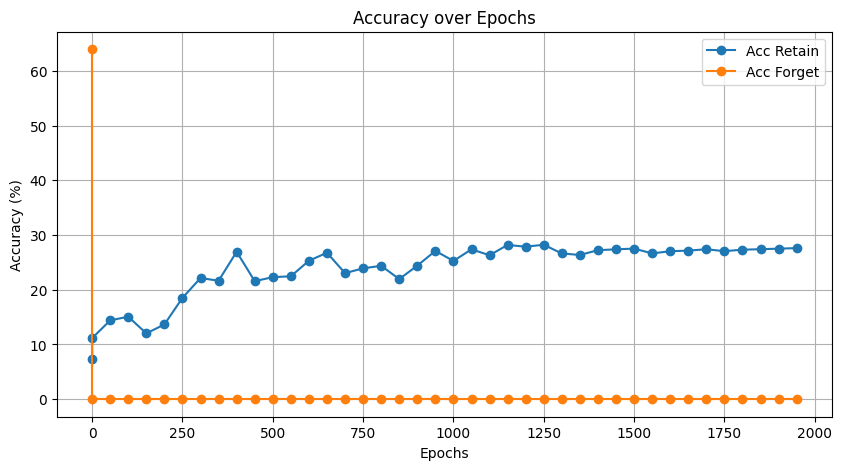

In [18]:
# Loop 1 Plot: Accuracy VS Epochs
import matplotlib.pyplot as plt

# Plot Acc Retain and Acc Forget over epochs
plt.figure(figsize=(10, 5))
plt.plot(df["Epochs"], df["AccRetain"], label='Acc Retain', marker='o')
plt.plot(df["Epochs"], df["AccForget"], label='Acc Forget', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Loop 2:
# total_pseudo_batches = 4000
# threshold = 0.01

import time

idx_pseudo = 0
total_n_pseudo_batches = 4000
n_pseudo_batches = 0
running_gen_loss = []
running_stu_loss = []

threshold = 0.01
KL_temperature = 1
AT_beta = 250

df = pd.DataFrame(columns=["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])

df = pd.concat([df, pd.DataFrame([{"Epochs": 0, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                   "ErrRetain": ErrRetain, "MeanGeneratorLoss": None, "MeanStudentLoss": None}])], ignore_index=True)

zero_count = 0

while n_pseudo_batches < total_n_pseudo_batches:
    epoch_start_time = time.time()  # Record the start time of the epoch

    x_pseudo = generator.__next__()

    preds = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]

    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits = student(x_pseudo)

        teacher_logits = model(x_pseudo)

        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())

    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):
        with torch.no_grad():
            teacher_logits = model(x_pseudo)

        student_logits = student(x_pseudo)

        student_activations_list = list(student_activations.values())
        teacher_activations_list = list(teacher_activations.values())

        student_total_loss = KT_loss_student(student_logits, student_activations_list,
                                             teacher_logits, teacher_activations_list,
                                             KL_temperature=KL_temperature, AT_beta=AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if (n_pseudo_batches % 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device=DEVICE)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device=DEVICE)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = pd.concat([df, pd.DataFrame([{"Epochs": n_pseudo_batches, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                               "ErrRetain": ErrRetain, "MeanGeneratorLoss": MeanGLoss, "MeanStudentLoss": MeanSLoss}])], ignore_index=True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history_forget[0]["Loss"])

            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_duration = epoch_end_time - epoch_start_time  # Calculate the duration
            print(f"Epoch {n_pseudo_batches} completed in {epoch_duration:.2f} seconds")


        n_pseudo_batches += 1

    idx_pseudo += 1


  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
1      0        0.0  11.160714   6.495994   4.471582          -0.135477   

   MeanStudentLoss  
1         9.880075  
Epoch 0 completed in 0.60 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
2     50        0.0  12.254465   5.669247    2.66957          -0.105935   

   MeanStudentLoss  
2         1.735884  
Epoch 50 completed in 0.74 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
3    100        0.0  13.649553   5.798112   2.333625          -0.139983   

   MeanStudentLoss  
3         1.777456  
Epoch 100 completed in 0.68 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
4    150        0.0   13.91741   7.420841   2.338364          -0.144064   

   MeanStudentLoss  
4         1.900177  
Epoch 150 completed in 0.71 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
5    200    

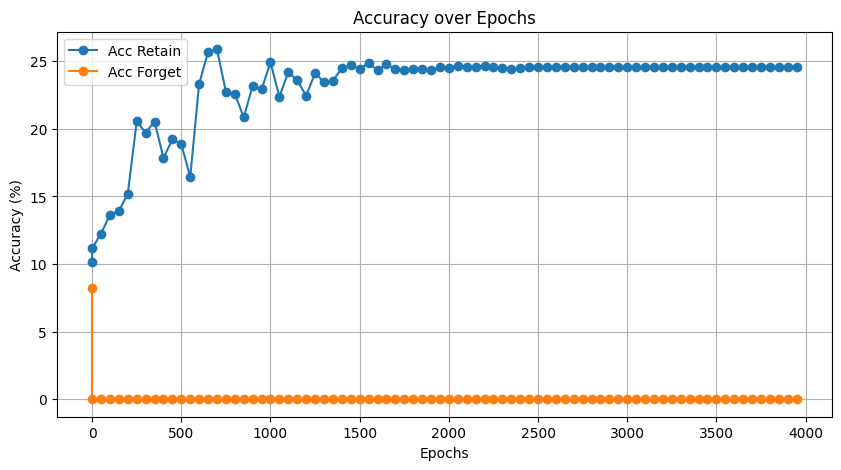

In [14]:
# Loop 2 Plot: Accuracy VS Epochs
import matplotlib.pyplot as plt

# Plot Acc Retain and Acc Forget over epochs
plt.figure(figsize=(10, 5))
plt.plot(df["Epochs"], df["AccRetain"], label='Acc Retain', marker='o')
plt.plot(df["Epochs"], df["AccForget"], label='Acc Forget', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Loop 3:
# total_pseudo_batches = 4000
# threshold = 0.02

import time

idx_pseudo = 0
total_n_pseudo_batches = 4000
n_pseudo_batches = 0
running_gen_loss = []
running_stu_loss = []

threshold = 0.02
KL_temperature = 2
AT_beta = 250

df = pd.DataFrame(columns=["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])

df = pd.concat([df, pd.DataFrame([{"Epochs": 0, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                   "ErrRetain": ErrRetain, "MeanGeneratorLoss": None, "MeanStudentLoss": None}])], ignore_index=True)

zero_count = 0

while n_pseudo_batches < total_n_pseudo_batches:
    epoch_start_time = time.time()  # Record the start time of the epoch

    x_pseudo = generator.__next__()

    preds = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]

    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits = student(x_pseudo)

        teacher_logits = model(x_pseudo)

        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())

    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):
        with torch.no_grad():
            teacher_logits = model(x_pseudo)

        student_logits = student(x_pseudo)

        student_activations_list = list(student_activations.values())
        teacher_activations_list = list(teacher_activations.values())

        student_total_loss = KT_loss_student(student_logits, student_activations_list,
                                             teacher_logits, teacher_activations_list,
                                             KL_temperature=KL_temperature, AT_beta=AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if (n_pseudo_batches % 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device=DEVICE)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device=DEVICE)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = pd.concat([df, pd.DataFrame([{"Epochs": n_pseudo_batches, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                               "ErrRetain": ErrRetain, "MeanGeneratorLoss": MeanGLoss, "MeanStudentLoss": MeanSLoss}])], ignore_index=True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history_forget[0]["Loss"])

            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_duration = epoch_end_time - epoch_start_time  # Calculate the duration
            print(f"Epoch {n_pseudo_batches} completed in {epoch_duration:.2f} seconds")


        n_pseudo_batches += 1

    idx_pseudo += 1


  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
1      0        0.0  11.160714   5.810602   6.675236          -0.084199   

   MeanStudentLoss  
1        11.096108  
Epoch 0 completed in 0.60 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
2     50        0.0  15.267856   4.849536    3.06631          -0.048116   

   MeanStudentLoss  
2          1.63892  
Epoch 50 completed in 0.66 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
3    100        0.0  16.484375   5.965597   2.890397          -0.073017   

   MeanStudentLoss  
3         1.827085  
Epoch 100 completed in 0.69 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
4    150        0.0  17.299107   5.413851   2.935211          -0.073995   

   MeanStudentLoss  
4         1.838088  
Epoch 150 completed in 0.67 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
5    200    

KeyboardInterrupt: 

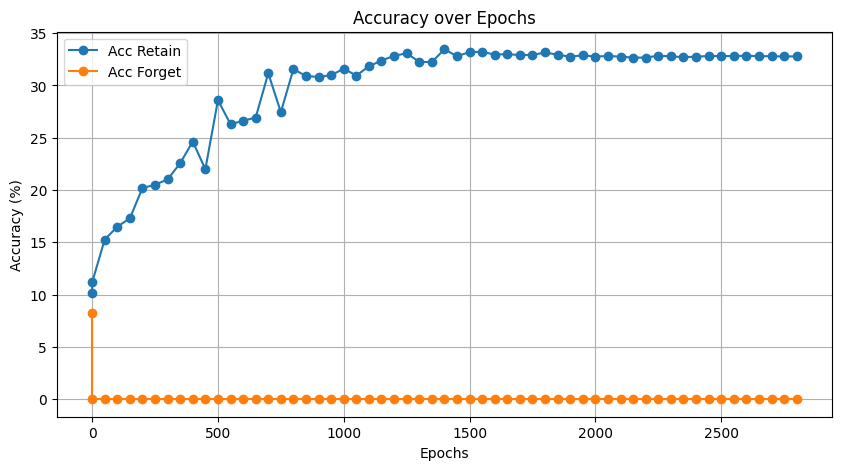

In [14]:
# Loop 3 Plot: Accuracy VS Epochs
import matplotlib.pyplot as plt

# Plot Acc Retain and Acc Forget over epochs
plt.figure(figsize=(10, 5))
plt.plot(df["Epochs"], df["AccRetain"], label='Acc Retain', marker='o')
plt.plot(df["Epochs"], df["AccForget"], label='Acc Forget', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Loop 4:
# total_pseudo_batches = 4000
# threshold = 4

import time

idx_pseudo = 0
total_n_pseudo_batches = 4000
n_pseudo_batches = 0
running_gen_loss = []
running_stu_loss = []

threshold = 4
KL_temperature = 2
AT_beta = 250

df = pd.DataFrame(columns=["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])

df = pd.concat([df, pd.DataFrame([{"Epochs": 0, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                   "ErrRetain": ErrRetain, "MeanGeneratorLoss": None, "MeanStudentLoss": None}])], ignore_index=True)

zero_count = 0

while n_pseudo_batches < total_n_pseudo_batches:
    epoch_start_time = time.time()  # Record the start time of the epoch

    x_pseudo = generator.__next__()

    preds = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]

    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits = student(x_pseudo)

        teacher_logits = model(x_pseudo)

        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())

    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):
        with torch.no_grad():
            teacher_logits = model(x_pseudo)

        student_logits = student(x_pseudo)

        student_activations_list = list(student_activations.values())
        teacher_activations_list = list(teacher_activations.values())

        student_total_loss = KT_loss_student(student_logits, student_activations_list,
                                             teacher_logits, teacher_activations_list,
                                             KL_temperature=KL_temperature, AT_beta=AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if (n_pseudo_batches % 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device=DEVICE)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device=DEVICE)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = pd.concat([df, pd.DataFrame([{"Epochs": n_pseudo_batches, "AccForget": AccForget, "AccRetain": AccRetain, "ErrForget": ErrForget,
                                               "ErrRetain": ErrRetain, "MeanGeneratorLoss": MeanGLoss, "MeanStudentLoss": MeanSLoss}])], ignore_index=True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history_forget[0]["Loss"])

            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_duration = epoch_end_time - epoch_start_time  # Calculate the duration
            print(f"Epoch {n_pseudo_batches} completed in {epoch_duration:.2f} seconds")


        n_pseudo_batches += 1

    idx_pseudo += 1


  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
1      0        0.0  11.160714   3.787273   9.179292          -0.082138   

   MeanStudentLoss  
1        11.117161  
Epoch 0 completed in 0.65 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
2     50  13.950893  12.377232   2.901126   3.570164          -0.055822   

   MeanStudentLoss  
2         1.789993  
Epoch 50 completed in 0.65 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
3    100   5.691964  17.712054   2.672401   2.830077           -0.06952   

   MeanStudentLoss  
3         1.652292  
Epoch 100 completed in 0.69 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
4    150   7.589286  17.455357   3.175813   2.848802          -0.075911   

   MeanStudentLoss  
4         1.795016  
Epoch 150 completed in 0.74 seconds
  Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
5    200   1

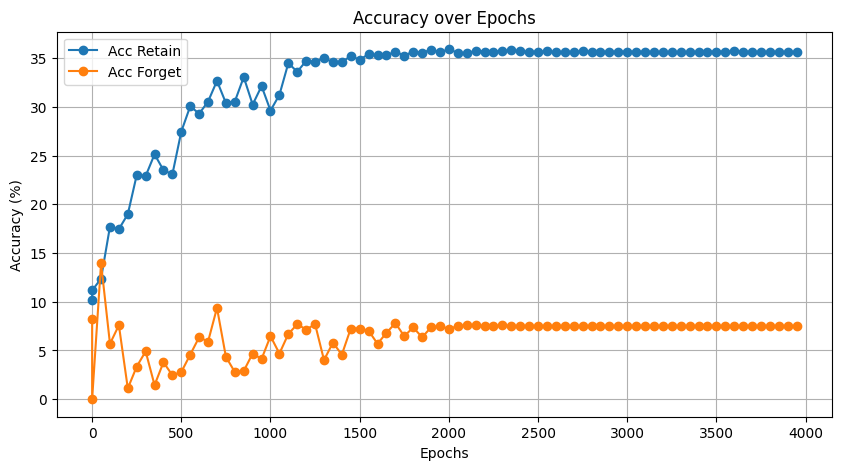

In [14]:
# Loop 4 Plot: Accuracy VS Epochs
import matplotlib.pyplot as plt

# Plot Acc Retain and Acc Forget over epochs
plt.figure(figsize=(10, 5))
plt.plot(df["Epochs"], df["AccRetain"], label='Acc Retain', marker='o')
plt.plot(df["Epochs"], df["AccForget"], label='Acc Forget', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()